In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
Nr = 400
alpha = 0.5
rho = 0.001
inputScaling = 1
biasScaling = 1
lam = 1
connectivity = 0.1

In [3]:
data = np.loadtxt("./Downloads/lienard_intermittency.dat")

In [ ]:
-0.44631594    0.80224762

In [4]:
train = data[:, 1][:45000]
test =  data[:, 1][45000:]

In [5]:
Win = np.random.uniform(-1, 1, Nr)
Wb = np.random.uniform(-1, 1, Nr) 
#Win = np.loadtxt("./EE_matrix/Win.txt")
#Wb = np.loadtxt("./EE_matrix/Wb.txt")

In [39]:
Win = Win.reshape(399)
Win = np.append(Win, -0.44631594)

Wb = Wb.reshape(399)
Wb = np.append(Wb, 0.802247624)

In [6]:
def erdos_renyi(n=1000, p=0.1):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if np.random.uniform(0, 1) > p:
                a = np.random.uniform(-1, 1)
                A[i][j] = a
                A[j][i] = a
                
        A[i][i] = 0
            
    return A

In [ ]:
0.00000000

In [7]:
Wres = erdos_renyi(400, 0.9)
#Wres = np.loadtxt("./EE_matrix/Wr.txt")

In [29]:
Wres = Wres.reshape(400**2-1)

In [30]:
Wres = np.append(Wres, 0.)

In [27]:
Wres

array([[0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [3.139e-05, 0.000e+00, 0.000e+00]])

In [32]:
Wres = Wres.reshape(400, 400)

In [11]:
np.sum(Wres!=0, axis=0).mean()

40.32

In [37]:
np.max(np.abs(np.linalg.eig(Wres)[0]))

0.0010000011477747674

In [9]:
Wres = Wres*(rho/np.max(np.linalg.eig(Wres)[0]))

In [10]:
np.linalg.eig(Wres)[0].max()

0.001000000000000008

In [12]:
N = len(train)
R = np.zeros((N, Nr))
r = np.random.uniform(-1, 1, Nr)
R[0] = r
for i in range(1, N):
    R[i] = (1-alpha)*R[i-1] + alpha*np.tanh(Wres@R[i-1] + Win*train[i-1] + Wb)

In [15]:
R.shape

(45000, 400)

In [47]:
R = np.loadtxt("./EE_matrix/X.txt")

In [48]:
R.shape

(6030000, 3)

In [49]:
R = (R.reshape(6030000*3)).reshape(45000, 402)

In [50]:
R

array([[ 1.        ,  0.43254869, -0.39348046, ..., -0.23350768,
        -0.31054888,  0.27177983],
       [ 1.        ,  0.43284042, -0.59024884, ..., -0.35034521,
        -0.46589821,  0.40755974],
       [ 1.        ,  0.43315921, -0.68867932, ..., -0.40883347,
        -0.54366184,  0.4753675 ],
       ...,
       [ 1.        ,  0.44758077, -0.79171437, ..., -0.47137871,
        -0.62883534,  0.53914585],
       [ 1.        ,  0.45033332, -0.79255533, ..., -0.47211538,
        -0.6301865 ,  0.53841433],
       [ 1.        ,  0.4538997 , -0.79362089, ..., -0.4730518 ,
        -0.63190003,  0.53748215]])

In [53]:
R[:, 2:]

array([[-0.39348046, -0.28443976, -0.15804836, ..., -0.23350768,
        -0.31054888,  0.27177983],
       [-0.59024884, -0.42670065, -0.23738268, ..., -0.35034521,
        -0.46589821,  0.40755974],
       [-0.68867932, -0.49787509, -0.27727253, ..., -0.40883347,
        -0.54366184,  0.4753675 ],
       ...,
       [-0.79171437, -0.5724496 , -0.32714981, ..., -0.47137871,
        -0.62883534,  0.53914585],
       [-0.79255533, -0.57307196, -0.32894123, ..., -0.47211538,
        -0.6301865 ,  0.53841433],
       [-0.79362089, -0.57386294, -0.33121722, ..., -0.4730518 ,
        -0.63190003,  0.53748215]])

In [26]:
Y = np.array(train).reshape(1, 45000)
X = R

In [24]:
X.shape

(45000, 400)

In [27]:
Wout = Y@X@np.linalg.inv(X.T@X + 1e-8**2*np.eye(400))

In [31]:
Wout@r

array([-42.8422685])

In [37]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=1e-8)
reg.fit(R, train)

Ridge(alpha=1e-08)

In [71]:
a = np.insert(r, 0, 2)

In [38]:
r = (1-alpha)*R[-1] + alpha*np.tanh(Wres@R[-1] + Win*train[-1] + Wb)
predicted = []
for i in range(len(test)):
    predicted.append(reg.predict(r.reshape(1, Nr)))
    r = (1-alpha)*r + alpha*np.tanh(Wres@r + Win*test[i] + Wb)
    

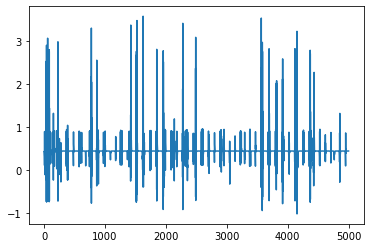

In [39]:
plt.plot(predicted)

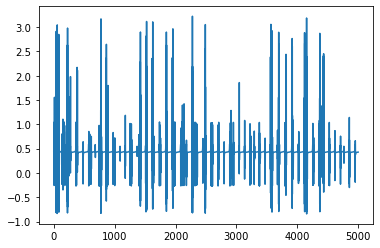

In [40]:
plt.plot(test)

In [41]:
(((np.array(predicted) - test)**2).mean())**0.5

0.4378487680195305